# Tectonic Model: Setting velocities / communicating with the UW Stokes system [WIP]

The TectonicModel has the capability of storing surface velocoty information for plates and plate boundaries. 

Here we show how this information can be communicated to teh UW2 simulation, by directly setting the velocity values on the surface nodes (Dirichlte boundary condition).

This notebook shows the general functionality, but does not constitute a working model. 



In [1]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator
import UWsubduction as usub
from UWsubduction import params
from underworld import scaling as sca
import pint
import os
import pickle


/opt/UWsubduction/UWsubduction/utils/__init__.py:9: UserWarning: 

The easymodels module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """


## Import some physical parameters

In [2]:
ur = uw.scaling.units
pint.set_application_registry(ur)

#Stored dictionaries holding physical parameters and model parameters
#See /UWsubduction/Examples/2d_subduction.ipynb

with open(os.path.join('./data/', 'pd.pkl'), 'rb') as fp:
        pd = pickle.load(fp)
with open(os.path.join('./data/', 'md.pkl'), 'rb') as fp:
        md = pickle.load(fp)
        

scaling_coefficients = sca.get_coefficients()

#instead of importing from the params submodule, we'll explicity set the scaling values
KL = pd.refLength
KT = pd.potentialTemp - pd.surfaceTemp
Kt = KL**2/pd.refDiffusivity            #we use a diffusive time scale 
KM = pd.refViscosity * KL * Kt

scaling_coefficients["[length]"]      = KL.to_base_units()
scaling_coefficients["[temperature]"] = KT.to_base_units()
scaling_coefficients["[mass]"]        = KM.to_base_units()
scaling_coefficients["[time]"] =        Kt.to_base_units()
        
        
#create dimensionless versions of the parameter dictionaries 
npd = params.build_nondim_dict(pd  , sca)   
nmd = params.build_nondim_dict(md  , sca)

## Build underworld mesh and fields

In [3]:
yres = int(nmd.res)
#you mant want to optimise xres, depending on how the mesh refinement is configured
xres = int(nmd.res*nmd.aspectRatio)  


halfWidth = 0.5*nmd.depth*nmd.aspectRatio 

#The origin of the x axis is in the centre of the box,
# The value of md.subZoneLoc is relative to the origin 
#The surface of the box has a value of 1.0 in the y axis, 
minCoord_    = (-1.*halfWidth, 1. - nmd.depth) 
maxCoord_    = (halfWidth, 1.)


periodic = [False, False]


mesh = uw.mesh.FeMesh_Cartesian( elementType = (nmd.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = minCoord_, 
                                 maxCoord    = maxCoord_, 
                                 periodic=periodic) 


temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)


temperatureField.data[:] = 0.
velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)


In [4]:
#(1. - mesh.minCoord[1])*2900

## Build plate model, with prescribed plate velocities

In [5]:
#Set up some plate velocites, times

vP1= sca.non_dimensionalise(2*ur.centimeter / ur.year)
vP2= sca.non_dimensionalise(-2*ur.centimeter / ur.year)

endTime = sca.non_dimensionalise(20*ur.megayear)
dt = sca.non_dimensionalise(0.1*ur.megayear)

endTime


7.504619732390011e-05

In [6]:

tm = usub.TectonicModel(mesh, 0, endTime, dt)

tm.add_plate(1, velocities = vP1)
tm.add_plate(2)
tm.add_plate(3, velocities = vP2)

In [7]:
tm.add_left_boundary(1)

tm.add_subzone(1, 2, nmd.subZoneLoc, subInitAge=nmd.slabAge, upperInitAge=nmd.upperPlateAgeAtTrench)
tm.add_subzone(3, 2., 0.4, subInitAge=nmd.slabAge, upperInitAge=nmd.upperPlateAgeAtTrench)

tm.add_right_boundary(3)


## Querying the velocities

In [8]:
time=tm.times[10]
for n in tm.nodes():
    if tm.plate_has_vel(n, time):
        print('plate {} has specified vel={}'.format(n, tm.plate_velocity(n, time) ))
    else:
        print('plate {} has no specified vel'.format(n))
    

for e in tm.undirected.edges():
    #print(e)

    if tm.is_subduction_boundary(e):
        n = tm.subduction_edge_order(e)[1]
        
        if tm.upper_plate_has_vel(e, time):
             print('upper plate {} has specified vel={}'.format(n, tm.plate_velocity(n, time) ))        

plate 1 has specified vel=1837.9483491674725
plate 2 has no specified vel
plate 3 has specified vel=-1837.9483491674725


## Determine surface nodes and set x velocity component

In [9]:
#set velocity to some pre-exiting value

velocityField.data[:] = 500.

In [60]:
dist = sca.non_dimensionalise(100e3*ur.meter)
testTime = sca.non_dimensionalise(4*ur.megayear)

#we're going set velocities on the top surface of our model
#but not all the way up to the plate boundaries
#i.e we'll push the plates in their interiors
#the mask function is how we'll discriminate these regions

MaskFn = tm.t2f(tm.plate_boundary_mask_fn(dist))

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, MaskFn))
fig.show()

AttributeError: 'function' object has no attribute 'non_dimensionalise'

In [11]:
#the nodes we'll set velocities on are those which have a value of 1 in teh MaskFn
#and correspond to plates where we have set velocities
nodes = tm.plate_vel_node_fn(testTime, maskFn = MaskFn)



#return an underworld fn.branching.map 
#which links plateIds (integers) to the specified plate velocities
pIdFn = tm.plate_id_fn()
velMapFn = tm.plateVelFn(testTime, pIdFn)

#Now set the velocity on the nodes
locs = tm.mesh.data[nodes]
velocityField.data[nodes, 0] = velMapFn.evaluate(locs)[:,0]

## Updating graph based on velocity information


The previous section showed how the tectonic model could be used to set velocities in the UW2 numercal model. 

In principal, this can be used to drive a 2d model according to an evolving kinematic model (i.e. where plate velocities are prescibed through time)

Perhaps the most challenging aspect of this, is keeping the TectonicModel object updated, so the plate boundary locations remain valid. 

Here we show two general utilities that may be useful in trying to keep track of plate boundary location:

First we show how to calculate the plate velocity at a plate's mid point. 

* this may be useful for evolving the location of a subduction boundary, based on the velocity of the upper plate

Second we show how to calculate maxima/minima in the horizontal compoonent of the x-velocity gradient (Vx,x) 

* this may be useful for tracking the evolving location of ridges or subduction zones. Ridges should correspond to peaks in (Vx,x), which subduction is associated with minima. 



Ultimately, the TeconicModel object uses setters to modify the plate boundary locations:

```
tm.set_bound_loc(platePair, newloc)
```
Where plate pair is a tuple containing teh platIds for a given boundary



## Determine plate mid-point velocities

In [14]:


tmUwMap = usub.tm_uw_map([], velocityField, [], 
                    [], [], [])

for n in tm.nodes():
    print('mid-plate-vel is {}'.format(usub.mid_plate_point_vel(tm, n, tmUwMap))  )

mid-plate-vel is [[ 1837.94834917   500.        ]]
mid-plate-vel is [[ 500.  500.]]
mid-plate-vel is [[-1837.94834917   500.        ]]



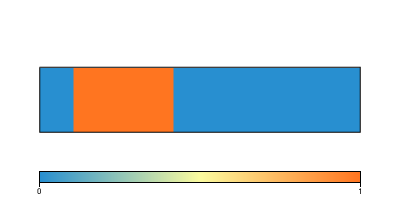

In [16]:
plate_interiorFn = tm.plate_interior_mask_fn(relativeWidth=0.6, minPlateLength=0.4, plate =1)


fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, tm.b2f(plate_interiorFn)))
fig.show()

## Using strain rate to determine plate boundaries location

In [45]:
dist = sca.non_dimensionalise(100e3*ur.meter)
MaskFn = tm.subduction_mask_fn(dist)


In [46]:
srLocMins, srLocMaxs = usub.strain_rate_min_max(tm, tmUwMap, tm.b2f(MaskFn))

In [58]:
#each of these contains the strain rate value (Vx,x), and the xposition

print(srLocMins) 


[(-248323.21360548015, 0.0)]


## Plot the plate velocity set on the nodes

Populating the interactive namespace from numpy and matplotlib


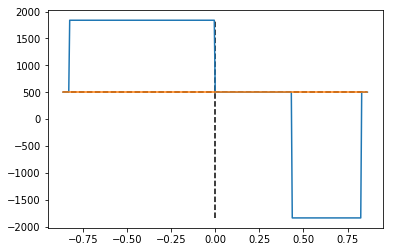

In [59]:
#check
%pylab inline
tWalls = tm.mesh.specialSets['MaxJ_VertexSet']

fig, ax = plt.subplots()
plt.plot(mesh.data[tWalls.data][:,0], velocityField.data[tWalls.data])

ax.hlines(500, tm.minX, tm.maxX, linestyles='--')


#xlocation of the strain rate min/max
ax.vlines(srLocMins[0][1], vP2, vP1, linestyles='--')
